In [11]:
#Base libraries
import numpy as np
import pandas as pd
import json
from typing import Dict

#Graph and algorithm-related libraries
import networkx as nx
from sklearn.cluster import DBSCAN

# For visualization
import open3d as o3d
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
try:
    from pxr import Usd, UsdGeom, Sdf, Gf, UsdShade
    USD_AVAILABLE = True
except ImportError:
    print("USD not available. Install with: pip install usd-core")
    USD_AVAILABLE = False

In [4]:
def load_semantic_point_cloud(file_path, column_name = 'semantic_label'):
    """Load semantic point cloud data from ASCII formats."""
        
    df = pd.read_csv(file_path, delimiter=';')
    class_names = ['ceiling', 'floor', 'wall', 'chair', 'furniture', 'table']
    
    # Assuming the numerical labels are 0.0, 1.0, 2.0, ...
    label_map = {float(i): class_names[i] for i in range(len(class_names))}
    
    df[column_name] = df[column_name].map(label_map)
    
    # I sample here for replication goals
    return df.sample(n=150000, random_state=1)

In [6]:
# Let us control the output of
raw_data = load_semantic_point_cloud('/home/parvez/Downloads/indoor_room_labelled.csv')
# I sample here for replication goals
demo_data = raw_data.sample(n=100000, random_state=1)

In [7]:
demo_data

,x,y,z,R,G,B,semantic_label
961377,4.435538,-6.123198,-3.919890,157,165,173,wall
434543,4.362929,0.202889,-5.852959,172,138,121,floor
519669,3.761103,2.719155,-5.878621,150,109,76,floor
304915,0.857803,-4.630533,-5.772312,134,101,76,floor
408096,3.501150,-2.758313,-5.812199,150,109,92,floor
...,...,...,...,...,...,...,...
837718,1.708935,-6.867329,-5.685557,160,127,118,wall
798123,1.066046,-5.530647,-4.724033,231,197,27,wall
547190,2.025179,1.300664,-5.850144,138,113,88,floor
912048,1.170835,-5.970364,-5.223693,179,154,146,wall


In [8]:
def visualize_semantic_pointcloud(df, point_size = 2.0):
    """Visualize semantic point cloud with flat colors per semantic label using Open3D."""
    
    # Extract coordinates
    points = df[['x', 'y', 'z']].values
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Create color mapping for semantic labels
    unique_labels = df['semantic_label'].unique()
    color_map = {}
    
    # Generate distinct colors for each label
    for i, label in enumerate(unique_labels):
        hue = i / len(unique_labels)
        color_map[label] = plt.cm.tab10(hue)[:3]
    
    # Assign colors based on semantic labels
    colors = np.array([color_map[label] for label in df['semantic_label']])
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Create visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Semantic Point Cloud", width=1200, height=800)
    vis.add_geometry(pcd)
    
    # Set point size
    render_option = vis.get_render_option()
    render_option.point_size = point_size
    
    print(f"Visualizing {len(points)} points with {len(unique_labels)} semantic classes:")
    for label in unique_labels:
        count = (df['semantic_label'] == label).sum()
        print(f"  {label}: {count} points")
    
    vis.run()
    vis.destroy_window()

In [9]:
# Time to have fun
visualize_semantic_pointcloud(demo_data, point_size=3.0)

Visualizing 100000 points with 6 semantic classes:
  wall: 31387 points
  floor: 35022 points
  table: 9295 points
  ceiling: 16791 points
  furniture: 3984 points
  chair: 3521 points


In [12]:
def extract_semantic_objects(df: pd.DataFrame, eps: float = 0.5, min_samples: int = 10) -> Dict:
    """Extract individual objects from semantic point cloud using clustering."""
    objects = {}
    
    for label in df['semantic_label'].unique():
        label_points = df[df['semantic_label'] == label]
        
        if len(label_points) < min_samples:
            continue
            
        # Apply DBSCAN clustering
        coords = label_points[['x', 'y', 'z']].values
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
        
        # Group by cluster
        label_points_copy = label_points.copy()
        label_points_copy['cluster'] = clustering.labels_
        
        for cluster_id in np.unique(clustering.labels_):
            if cluster_id == -1:  # Skip noise points
                continue
                
            cluster_points = label_points_copy[label_points_copy['cluster'] == cluster_id]
            object_key = f"{label}_{cluster_id}"
            
            objects[object_key] = {
                'points': cluster_points,
                'centroid': cluster_points[['x', 'y', 'z']].mean().values,
                'bounds': {
                    'min': cluster_points[['x', 'y', 'z']].min().values,
                    'max': cluster_points[['x', 'y', 'z']].max().values
                },
                'semantic_label': label,
                'point_count': len(cluster_points)
            }
    
    return objects

In [18]:
objects = extract_semantic_objects(demo_data)

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

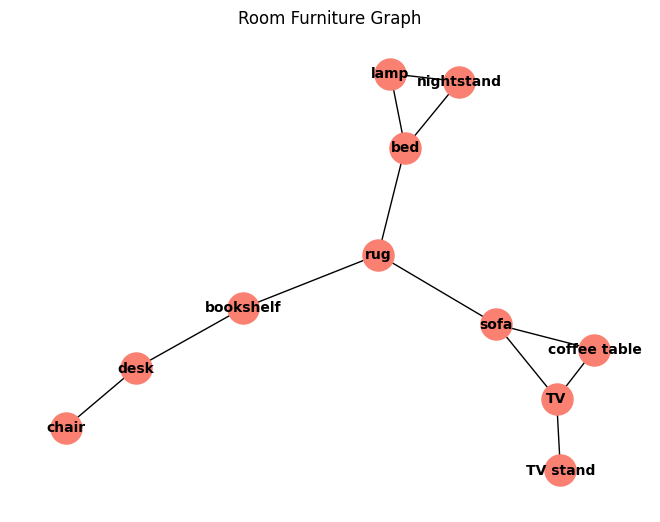

In [14]:
def visualize_room_furniture_graph(furniture_data):
    """Builds and visualizes a graph of room furniture."""
    
    G = nx.Graph()
    for item, connections in furniture_data.items():
        G.add_node(item)
        for connected_item in connections:
            G.add_edge(item, connected_item)
    pos = nx.spring_layout(G, seed=42)  # For reproducible layout
    nx.draw(G, pos, with_labels=True, node_color='salmon',
            node_size=500, font_size=10, font_weight='bold')
    plt.title("Room Furniture Graph")
    plt.show()
# Example of a room description:
room_layout = {
    "bed": ["nightstand", "lamp", "rug"],
    "nightstand": ["bed", "lamp"],
    "lamp": ["bed", "nightstand"],
    "rug": ["bed", "sofa", "bookshelf"],
    "sofa": ["coffee table", "TV", "rug"],
    "coffee table": ["sofa", "TV"],
    "TV": ["sofa", "coffee table", "TV stand"],
    "TV stand": ["TV"],
    "bookshelf": ["desk"],
    "desk": ["bookshelf", "chair"],
    "chair": ["desk"]
}
visualize_room_furniture_graph(room_layout)

In [19]:
def estimate_surface_area(points):
    from scipy.spatial import ConvexHull
    try:
        hull = ConvexHull(points)
        return hull.area  # Surface area of convex hull
    except:
        return 0.0  # Fallback for degenerate cases

In [20]:
def compute_object_features(objects):
    """Compute geometric and semantic features for each object."""
    features = {}
    
    for obj_name, obj_data in objects.items():
        points = obj_data['points'][['x', 'y', 'z']].values
        
        # Geometric features
        volume = np.prod(obj_data['bounds']['max'] - obj_data['bounds']['min'])
        surface_area = estimate_surface_area(points)
        compactness = (surface_area ** 3) / (36 * np.pi * volume ** 2) if volume > 0 else 0
        
        features[obj_name] = {
            'volume': volume,
            'surface_area': surface_area,
            'compactness': compactness,
            'height': obj_data['bounds']['max'][2] - obj_data['bounds']['min'][2],
            'semantic_label': obj_data['semantic_label'],
            'centroid': obj_data['centroid'],
            'point_density': obj_data['point_count'] / volume if volume > 0 else 0
        }
    
    return features

In [21]:
# Let us compute our features
features = compute_object_features(objects)

In [23]:
def is_contained(bounds1, bounds2):
    """Check if object1 is contained within object2."""
    return (np.all(bounds1['min'] >= bounds2['min']) and 
            np.all(bounds1['max'] <= bounds2['max']))

In [24]:
def are_adjacent(bounds1, bounds2, tolerance=0.1):
    # Check if faces are close along each axis
    for axis in range(3):  # X, Y, Z axes
        # Face-to-face proximity checks
        if (abs(bounds1['max'][axis] - bounds2['min'][axis]) < tolerance or
            abs(bounds2['max'][axis] - bounds1['min'][axis]) < tolerance):
            return True
    return False

In [25]:
def determine_relationship_type(obj1, obj2, threshold):
    centroid1 = obj1['centroid']
    centroid2 = obj2['centroid']
    
    distance = np.linalg.norm(centroid1 - centroid2)
    if distance > threshold:
        return None  # Too far apart
    
    # Vertical relationship analysis
    z_diff = centroid1[2] - centroid2[2]
    if abs(z_diff) > 0.5:  # Significant height difference
        return 'above' if z_diff > 0 else 'below'
    
    # Containment analysis
    bounds1 = obj1['bounds']
    bounds2 = obj2['bounds']
    
    if is_contained(bounds1, bounds2):
        return 'inside'
    elif is_contained(bounds2, bounds1):
        return 'contains'
    
    # Adjacency analysis
    if are_adjacent(bounds1, bounds2, tolerance=0.3):
        return 'adjacent'
    
    return 'near'  # Default fallback

In [26]:
def compute_spatial_relationships(objects, distance_threshold=2.0):
    relationships = []
    object_names = list(objects.keys())
    
    for i, obj1 in enumerate(object_names):
        for j, obj2 in enumerate(object_names[i+1:], i+1):  # Avoid duplicates
            rel_type = determine_relationship_type(objects[obj1], objects[obj2], distance_threshold)
            if rel_type:  # Only keep valid relationships
                relationships.append((obj1, obj2, rel_type))
    
    return relationships

In [31]:
def build_scene_graph(objects, relationships, features):
    G = nx.DiGraph()
    
    # Add nodes with rich attributes
    for obj_name, obj_data in objects.items():
        obj_features = features.get(obj_name, {}).copy()
        obj_features.pop('semantic_label', None)  # Avoid conflicts

        # Remove conflicting keys
        obj_features.pop('semantic_label', None)
        obj_features.pop('centroid', None) 
        
        G.add_node(obj_name, 
                  semantic_label=obj_data['semantic_label'],
                  centroid=obj_data['centroid'].tolist(),
                  point_count=obj_data['point_count'],
                  **obj_features)
    
    # Add relationship edges
    for obj1, obj2, rel_type in relationships:
        G.add_edge(obj1, obj2, relationship=rel_type)
    
    return G

In [36]:
def visualize_scene_graph(G):
    """Visualize the scene graph with semantic labels and relationships."""
    pos = nx.spring_layout(G, seed=42)  # Layout for reproducibility
    
    # Draw nodes with semantic label as color
    labels = nx.get_node_attributes(G, 'semantic_label')
    unique_labels = list(set(labels.values()))
    color_map = {lbl: plt.cm.tab10(i % 10) for i, lbl in enumerate(unique_labels)}
    node_colors = [color_map[labels[node]] for node in G.nodes()]
    
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=600, font_size=8, font_weight="bold")
    
    # Draw edge labels (relationships)
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    # Legend
    patches = [mpatches.Patch(color=color_map[lbl], label=lbl) for lbl in unique_labels]
    plt.legend(handles=patches, title="Semantic Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title("Scene Graph")
    plt.show()

In [37]:
def analyze_scene_graph(G):
    analysis = {
        'node_count': G.number_of_nodes(),
        'edge_count': G.number_of_edges(),
        'semantic_distribution': {},
        'relationship_types': {},
        'connected_components': nx.number_weakly_connected_components(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
    }
    
    # Analyze semantic distribution
    for node, data in G.nodes(data=True):
        label = data.get('semantic_label', 'unknown')
        analysis['semantic_distribution'][label] = analysis['semantic_distribution'].get(label, 0) + 1
    
    # Analyze relationship types
    for _, _, data in G.edges(data=True):
        rel = data.get('relationship', 'unknown')
        analysis['relationship_types'][rel] = analysis['relationship_types'].get(rel, 0) + 1

In [38]:
# Compute relationships between objects
relationships = compute_spatial_relationships(objects)


In [45]:
# Build the scene graph
G = build_scene_graph(objects, relationships, features)

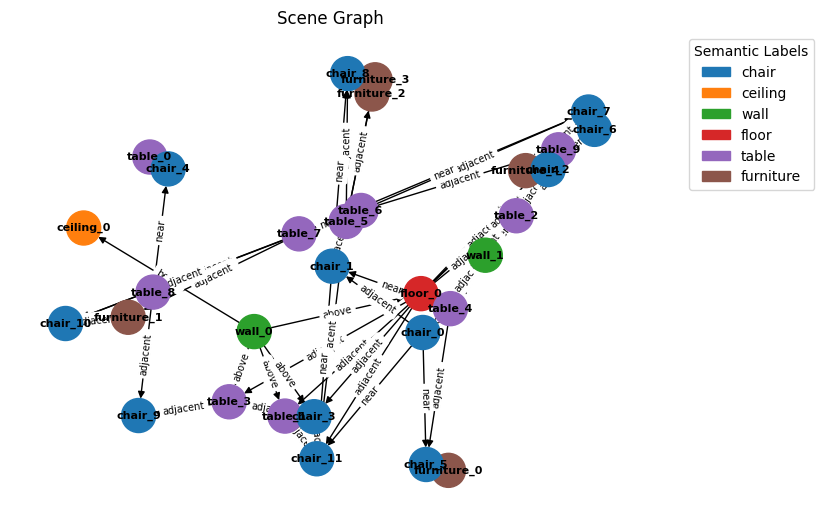

In [46]:
visualize_scene_graph(G)

In [41]:
def create_pattern_matcher(scene_graph, pattern_graph, 
                          node_attr='semantic_label', 
                          edge_attr='relationship'):
    """Create flexible pattern matcher for scene graph analysis."""
    
    def semantic_node_match(node1_attrs, node2_attrs):
        """Check if nodes match semantically with flexibility."""
        label1 = node1_attrs.get(node_attr, 'unknown')
        label2 = node2_attrs.get(node_attr, 'unknown')
        
        # Exact match first
        if label1 == label2:
            return True
            
        # Semantic equivalence groups
        furniture_group = {'chair', 'seat', 'stool'}
        surface_group = {'table', 'desk', 'surface'}
        
        if label1 in furniture_group and label2 in furniture_group:
            return True
        if label1 in surface_group and label2 in surface_group:
            return True
            
        return False
    
    def relationship_edge_match(edge1_attrs, edge2_attrs):
        """Check if relationships match with spatial tolerance."""
        rel1 = edge1_attrs.get(edge_attr, 'unknown')
        rel2 = edge2_attrs.get(edge_attr, 'unknown')
        
        # Direct match
        if rel1 == rel2:
            return True
            
        # Spatial relationship equivalence
        proximity_group = {'adjacent', 'near', 'close'}
        support_group = {'above', 'on', 'supported_by'}
        
        if rel1 in proximity_group and rel2 in proximity_group:
            return True
        if rel1 in support_group and rel2 in support_group:
            return True
            
        return False
    
    # Create NetworkX matcher with custom comparison functions
    matcher = nx.algorithms.isomorphism.DiGraphMatcher(
        scene_graph,
        pattern_graph,
        node_match=semantic_node_match,
        edge_match=relationship_edge_match
    )
    
    return matcher

In [42]:
def create_meeting_room_pattern():
    """Define meeting room spatial pattern as scene graph."""
    pattern = nx.DiGraph()
    
    # Core meeting room components
    pattern.add_node('table_1', semantic_label='table')
    pattern.add_node('chair_1', semantic_label='chair')
    pattern.add_node('chair_2', semantic_label='chair')
    pattern.add_node('chair_3', semantic_label='chair')
    
    # Spatial relationships
    pattern.add_edge('chair_1', 'table_1', relationship='adjacent')
    pattern.add_edge('chair_2', 'table_1', relationship='adjacent')
    pattern.add_edge('chair_3', 'table_1', relationship='adjacent')
    
    return pattern

def create_workstation_pattern():
    """Define individual workstation spatial pattern."""
    pattern = nx.DiGraph()
    
    # Workstation components
    pattern.add_node('desk_1', semantic_label='desk')
    pattern.add_node('chair_1', semantic_label='chair')
    pattern.add_node('storage_1', semantic_label='furniture')
    
    # Functional relationships
    pattern.add_edge('chair_1', 'desk_1', relationship='adjacent')
    pattern.add_edge('storage_1', 'desk_1', relationship='near')
    
    return pattern
def find_spatial_patterns(scene_graph, pattern_graph):
    """Find all occurrences of pattern within scene graph."""
    matcher = create_pattern_matcher(scene_graph, pattern_graph)
    
    matches = list(matcher.subgraph_isomorphisms_iter())
    
    # Extract match details with spatial context
    pattern_matches = []
    for match in matches:
        # match maps pattern nodes to scene nodes
        scene_objects = list(match.values())
        
        # Calculate pattern centroid for spatial reference
        centroids = []
        for obj_id in scene_objects:
            if scene_graph.has_node(obj_id):
                centroid = scene_graph.nodes[obj_id].get('centroid', [0,0,0])
                centroids.append(centroid)
        
        if centroids:
            pattern_center = np.mean(centroids, axis=0)
            pattern_matches.append({
                'objects': scene_objects,
                'mapping': match,
                'center': pattern_center.tolist(),
                'confidence': calculate_pattern_confidence(scene_graph, match)
            })
    
    return pattern_matches
def calculate_pattern_confidence(scene_graph, node_mapping):
    """Calculate confidence score for pattern match."""
    confidence_factors = []
    
    # Geometric consistency
    positions = []
    for scene_node in node_mapping.values():
        centroid = scene_graph.nodes[scene_node].get('centroid', [0,0,0])
        positions.append(centroid)
    
    if len(positions) > 1:
        # Measure spatial compactness
        distances = []
        for i, pos1 in enumerate(positions):
            for pos2 in positions[i+1:]:
                distances.append(np.linalg.norm(np.array(pos1) - np.array(pos2)))
        
        avg_distance = np.mean(distances)
        # Lower average distance = higher confidence for compact patterns
        spatial_confidence = max(0, 1.0 - avg_distance / 5.0)  # 5m normalization
        confidence_factors.append(spatial_confidence)
    
    # Semantic consistency (could add more factors)
    semantic_confidence = 1.0  # Placeholder for semantic validation
    confidence_factors.append(semantic_confidence)
    
    return np.mean(confidence_factors)

In [48]:
# Pick which pattern to detect
pattern = create_meeting_room_pattern()   # or create_workstation_pattern()

In [57]:
matcher = nx.algorithms.isomorphism.DiGraphMatcher(
    G,
    pattern,
    node_match=lambda d1, d2: d1.get("semantic_label") == d2.get("semantic_label"),
    edge_match=lambda d1, d2: d1.get("relationship") == d2.get("relationship"),
)

for match in matcher.subgraph_isomorphisms_iter():
    print("Pattern found:", match)


In [58]:
def create_usd_stage(scene_graph: nx.DiGraph, output_path: str) -> bool:
    """Create USD stage from scene graph and export to file."""
    if not USD_AVAILABLE:
        print("USD not available. Cannot create USD stage.")
        return False
    
    # Create new stage
    stage = Usd.Stage.CreateNew(output_path)
    
    # Set up scene hierarchy
    root_prim = stage.DefinePrim('/Scene', 'Xform')
    stage.SetDefaultPrim(root_prim)
    
    # Create geometry scope for objects
    geom_scope = UsdGeom.Scope.Define(stage, '/Scene/Geometry')
    
    # Add each object as a primitive
    for node, data in scene_graph.nodes(data=True):
        create_usd_object(stage, node, data)
    
    # Add relationships as metadata
    add_relationships_to_stage(stage, scene_graph)
    
    # Save stage
    stage.Save()
    return True

In [59]:
def process_semantic_pointcloud_to_usd(input_path, output_usd, eps = 0.8, min_samples = 15, distance_threshold = 3.0):
    """Complete pipeline from semantic point cloud to USD scene graph."""
    results = {'success': False, 'files_created': [], 'analysis': {}}
    
    try:
        # Load and validate data
        print("Loading semantic point cloud...")
        df = load_semantic_point_cloud(input_path)
        
        print(f"Loaded {len(df)} points with {df['semantic_label'].nunique()} semantic classes")
        
        # Extract objects
        print("Extracting semantic objects...")
        objects = extract_semantic_objects(df, eps=eps, min_samples=min_samples)
        print(f"Found {len(objects)} objects")
        
        # Compute features
        print("Computing object features...")
        features = compute_object_features(objects)
        
        # Find relationships
        print("Computing spatial relationships...")
        relationships = compute_spatial_relationships(objects, distance_threshold)
        print(f"Found {len(relationships)} spatial relationships")
        
        # Build scene graph
        print("Building scene graph...")
        scene_graph = build_scene_graph(objects, relationships, features)
        
        # Validate scene graph
        validation = validate_scene_graph(scene_graph)
        if not validation['is_valid']:
            print("Warning: Scene graph validation found issues:", validation['issues'])
        
        # Export to USD
        if USD_AVAILABLE:
            print(f"Exporting to USD: {output_usd}")
            usd_success = create_usd_stage(scene_graph, output_usd)
            if usd_success:
                results['files_created'].append(output_usd)
        
        # Export summary
        summary_path = output_usd.replace('.usda', '_summary.json')
        export_scene_summary(scene_graph, summary_path)
        results['files_created'].append(summary_path)
        
        # Store analysis results
        results['analysis'] = analyze_scene_graph(scene_graph)
        results['validation'] = validation
        results['success'] = True
        
        print("Pipeline completed successfully!")
        
    except Exception as e:
        print(f"Pipeline failed: {str(e)}")
        results['error'] = str(e)
    
    return results

In [61]:
# Complete pipeline execution
process_semantic_pointcloud_to_usd('/home/parvez/Downloads/indoor_room_labelled.csv', 'demo_scene_c.usda', eps = 0.2, min_samples = 20, distance_threshold = 3.0)

Loading semantic point cloud...
Loaded 150000 points with 6 semantic classes
Extracting semantic objects...
Found 38 objects
Computing object features...
Computing spatial relationships...
Found 223 spatial relationships
Building scene graph...
Pipeline failed: name 'validate_scene_graph' is not defined


{'success': False,
 'files_created': [],
 'analysis': {},
 'error': "name 'validate_scene_graph' is not defined"}

In [64]:
def query_scene_with_llm(scene_graph: nx.DiGraph, user_question: str, 
                        llm_client=None) -> str:
    """Query scene graph using LLM reasoning capabilities."""
    
    # Create structured scene description
    scene_context = scene_graph_to_llm_prompt(scene_graph)
    
    # Build complete prompt
    full_prompt = f"""{scene_context}

USER QUESTION: {user_question}
Please provide a detailed answer based on the spatial relationships and object positions in the scene. Consider:
1. Direct spatial relationships between objects
2. Accessibility and navigation paths
3. Functional groupings and usage patterns
4. Safety or optimization concerns"""